# 0212 - 파이프라인v2 + Model training
- 대용량 데이터를 사용하기위해 승순님의 파이프라인 버전2 코드를 사용하기로 결정
    - raw 데이터를 샘플링해서 chunk파일로 만든 gz파일을 활용해서 학습했을때 한 에폭당 840초 가량으로 확연히 줄어듬


👉 **raw 청크 데이터를 다운받아서 모델을 실험해보기로 결정**

# = Download raw data =

In [10]:
file_id="" # id값은 코드 실행후 삭제
file_name="raw_shuffle_data.zip"
!curl -sc /tmp/cookie "https://drive.google.com/uc?export=download&id=${file_id}" > /dev/null
!code="$(awk '/_warning_/ {print $NF}' /tmp/cookie)"
!curl -Lb /tmp/cookie "https://drive.google.com/uc?export=download&confirm=${code}&id=${file_id}" -o ${file_name}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1555  100  1555    0     0  20733      0 --:--:-- --:--:-- --:--:-- 20733


In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=${file_id}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=${file_id}" -O raw_shuffle_data.zip && rm -rf /tmp/cookies.txt

- 데이터 용량이 너무 커서 다운받는데 계속 실패 : 실제 용량은 60GB 정도인데 2.37K 의 데이터만 다운받아짐
```
    HTTP request sent, awaiting response... 200 OK
Length: 2431 (2.4K) [text/html]
Saving to: ‘raw_shuffle_data.zip’
raw_shuffle_data.zi 100%[===================>]   2.37K  --.-KB/s    in 0s      
2024-02-12 05:23:25 (27.6 MB/s) - ‘raw_shuffle_data.zip’ saved [2431/2431]
```

- 터미널에서 shell script를 활용해서 wget, curl 명령어로 시도했으나 대용량파일에 대한 경고 페이지를 무시하고 진행하는 스크립트를 만드는데 실패 -> 다운로드 실패


👉 **gz 파일의 1개를 따로 받아서 해당 파일로 모델 실험을 진행**

---

# = Pipeline v2 test =

In [25]:
# import pipeline.v2 library
'''
파이프라인v2에서 중요하게 사용하는 draw_strokes함수를 Img_data_generator 클래스에 넣어서
py파일로 만들고 import해옴

-- 변경사항 --
PEP 8 파이썬 코딩스타일에 맞춰서 클래스 이름 변경 
    : Img_data_generator -> ImgDataGenerator

'''
from img_data_generator import ImgDataGenerator # 파일을 하나씩 넘겨주는 generator 클래스

In [1]:
# import basic library
import pandas as pd      # pandas 라이브러리를 pd로 가져오기
import numpy as np       # numpy 라이브러리를 np로 가져오기
import os                # os 라이브러리 가져오기
import json              # json 라이브러리 가져오기
import cv2               # OpenCV 라이브러리 가져오기
import tensorflow as tf  # TensorFlow 라이브러리 가져오기
from tensorflow.keras.utils import to_categorical  # TensorFlow의 to_categorical 함수 가져오기
import matplotlib.pyplot as plt

In [2]:
# load label_names pkl file : data lable이 리스트로 담겨있는 파일

import pickle

with open('../data/label_names.pkl', 'rb') as f:
    label_names = pickle.load(f)

In [3]:
label_names[:5]

['key', 'bus', 'apple', 'fire hydrant', 'marker']

In [4]:
# 파일 경로 설정
data_folder_path = '../data'
train_file_path = os.path.join(data_folder_path, 'train_simplified')
base_path = train_file_path + '/shuffle_raw_gzs'
num_files = 1  # 사용할 파일 개수 지정
df_files = [os.path.join(base_path, f'train_k{k}.gz') for k in range(num_files)]

# 파일 리스트 확인
print("경량화 시킨 gz 파일의 수:", len(df_files))

경량화 시킨 gz 파일의 수: 1


In [36]:
# ImgDataGenerator 인스턴스 생성을 위한 설정
input_shape = (128, 128, 3)  # 입력 이미지의 형태 (높이, 너비, 채널)
batch_size = 25  # 배치 사이즈

# ImgDataGenerator 클래스의 인스턴스 생성
## state: DataCheck로 설정해서 Train 준비에서 제외
gen_data_check = ImgDataGenerator(df_files=df_files, input_shape=input_shape, batchsize=batch_size, label_names=label_names, num_files=num_files, state='DataCheck', lw=2)

# 첫 번째 배치 데이터 가져오기 및 시각화
xx, y = gen_data_check[0]
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
labels = np.argmax(y, axis=1)  # 레이블 인덱스

# 이미지를 0에서 1 사이의 값으로 변환
xx = xx.astype(float) / 255.0

# 5x5 그리드에서 각 셀에 대해 이미지를 시각화하는 반복문
for i in range(25):
    axs[i // 5, i % 5].imshow(xx[i])  # 이미지 플로팅
    axs[i // 5, i % 5].axis('off')  # 축 숨기기
    axs[i // 5, i % 5].set_title(gen_data_check.label_names[labels[i]])  # 레이블 이름 설정

plt.show()

오류가 발생한 파일: ../data/train_simplified/shuffle_raw_gzs/train_k0.gz
오류 상세 정보: name 'draw_strokes' is not defined


NameError: name 'draw_strokes' is not defined

- draw_strokes 함수를 클래스 안에 포함시킬때 클래스 안에서 사용하는 변수앞에 self.를 모두 붙였다고 생각했는데 반복해서 에러가 남
- 일단 함수와 클래스를 여기에서 직접 실행하는 방식으로 수정


👉 **미팅때 이 내용을 공유하고 문제를 해결해보기로 결정**

In [5]:
# draw_strokes function : 좌표값을 이미지로 만드는 함수
def draw_strokes(raw_strokes, image_size=128, line_width=6):
    border_offset = line_width * 2  # 테두리 공백 크기
    stroke_list = []  # raw_strokes를 NumPy 배열로 변환한 리스트
    bounds_info = {"min_x": float('inf'), "min_y": float('inf'),  # 최소 x, y 좌표 초기화
                   "max_x": float('-inf'), "max_y": float('-inf')}  # 최대 x, y 좌표 초기화
    
    # raw_strokes의 각 stroke에 대해 NumPy 배열로 변환하고 경계 좌표 갱신
    for stroke in raw_strokes:
        np_stroke = np.array(stroke)  # stroke를 NumPy 배열로 변환
        stroke_list.append(np_stroke)    # 변환된 배열을 stroke_list에 추가
        # 최소/최대 x, y 좌표 갱신
        bounds_info["min_x"] = min(bounds_info["min_x"], min(np_stroke[0]))
        bounds_info["max_x"] = max(bounds_info["max_x"], max(np_stroke[0]))
        bounds_info["min_y"] = min(bounds_info["min_y"], min(np_stroke[1]))
        bounds_info["max_y"] = max(bounds_info["max_y"], max(np_stroke[1]))
    
    # 빈 이미지 생성
    new_image = np.zeros((image_size, image_size, 3), dtype=float)
    original_width = bounds_info["max_x"] - bounds_info["min_x"]  # 원본 그림의 너비
    original_height = bounds_info["max_y"] - bounds_info["min_y"]  # 원본 그림의 높이
    ratio = max(original_width, original_height) / (image_size - border_offset * 2)  # 비율 계산
    
    # 비율이 0일 경우 빈 이미지 반환
    if ratio == 0:
        return new_image

    # 각 stroke의 좌표를 새로운 크기에 맞게 조정하여 이미지에 그리기
    for np_stroke in stroke_list:
        np_stroke[0] = (np_stroke[0] - bounds_info["min_x"]) / ratio + border_offset  # x 좌표 조정
        np_stroke[1] = (np_stroke[1] - bounds_info["min_y"]) / ratio + border_offset  # y 좌표 조정
        # 선 그리기
        for i in range(len(np_stroke[0]) - 1):
            start_x, start_y = int(np_stroke[0][i]), int(np_stroke[1][i])  # 시작점 좌표
            end_x, end_y = int(np_stroke[0][i + 1]), int(np_stroke[1][i + 1])  # 끝점 좌표
            new_image = cv2.line(new_image, (start_x, start_y), (end_x, end_y), (255, 255, 255), line_width)  # 선 그리기
    
    return new_image  # 완성된 이미지 반환

In [6]:
# ImgDataGenerator Class

import pandas as pd
import numpy as np
import json
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import cv2               # OpenCV 라이브러리 가져오기

# 파일을 하나씩 넘겨주는 generator
class ImgDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df_files, input_shape, batchsize, label_names, num_files, lw=3, state='Train', smoothing_factor=0.1):
        # 클래스 초기화 함수
        self.df_files = sorted(df_files)[:num_files]  # 데이터프레임 파일 리스트, 파일명 기준 오름차순 정렬 후 지정된 개수만큼 선택
        self.file_sel = 0  # 현재 사용할 파일 인덱스
        self.batchsize = batchsize  # 배치 크기
        self.input_shape = input_shape  # 입력 이미지 모양
        self.label_names = label_names  # 레이블 이름
        self.lw = lw  # 선의 너비
        self.state = state  # 상태 (Train, Test)
        self.smoothing_factor = smoothing_factor  # 스무딩 팩터
        self.on_epoch_end()  # epoch 종료시 호출

    def smooth_labels(self, labels):
        # 레이블을 부드럽게 만드는 함수
        labels *= (1 - self.smoothing_factor)
        labels += (self.smoothing_factor / len(self.label_names))
        return labels

    def __len__(self):
        # 데이터셋의 길이 반환
        return -(-len(self.df) // self.batchsize)
    
    def __getitem__(self, index):
        # 주어진 인덱스에 해당하는 데이터 가져오기
        try:
            batch_idx = self.idx[index * self.batchsize:(index + 1) * self.batchsize]
            h, w, ch = self.input_shape
            X = np.zeros((len(batch_idx), h, w, ch))
            y = np.zeros((len(batch_idx), len(self.label_names)))

            for i, idx in enumerate(batch_idx):
                row = self.df.iloc[idx]
                raw_strokes = json.loads(row['drawing'])
                # draw_strokes 함수 호출하여 이미지 데이터 생성
                X[i, :, :, ] = draw_strokes(raw_strokes, image_size=h, line_width=self.lw)

                if self.state != 'Test':
                    label_index = row['y']
                    label = to_categorical(label_index, num_classes=len(self.label_names))
                    y[i, :] = self.smooth_labels(label)

            return (X, y) if self.state != 'Test' else X
        
        except Exception as e:
            print(f"오류가 발생한 파일: {self.df_files[self.file_sel]}")
            print(f"오류 상세 정보: {e}")
            raise e

    def on_epoch_end(self):
        # epoch 종료시 호출되는 함수
        try:
            self.df = pd.read_csv(self.df_files[self.file_sel], compression='gzip')  # .gz 파일 읽기 추가
            self.idx = np.tile(np.arange(len(self.df)), 2)
            if self.state == 'Train':
                np.random.shuffle(self.idx)
            self.file_sel = (self.file_sel + 1) % len(self.df_files)
            
        except Exception as e:
            print

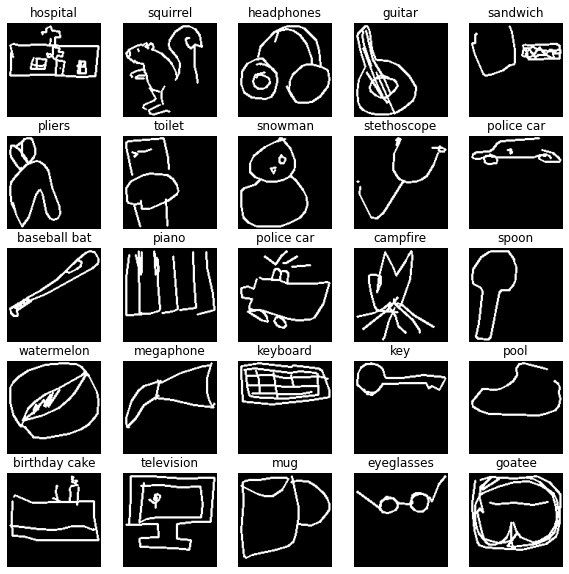

In [7]:
# ImgDataGenerator 인스턴스 생성을 위한 설정
input_shape = (128, 128, 3)  # 입력 이미지의 형태 (높이, 너비, 채널)
batch_size = 25  # 배치 사이즈

# ImgDataGenerator 클래스의 인스턴스 생성
## state: DataCheck로 설정해서 Train 준비에서 제외
gen_data_check = ImgDataGenerator(df_files=df_files, input_shape=input_shape, batchsize=batch_size, label_names=label_names, num_files=num_files, state='DataCheck', lw=2)

# 첫 번째 배치 데이터 가져오기 및 시각화
xx, y = gen_data_check[0]
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
labels = np.argmax(y, axis=1)  # 레이블 인덱스

# 이미지를 0에서 1 사이의 값으로 변환
xx = xx.astype(float) / 255.0

# 5x5 그리드에서 각 셀에 대해 이미지를 시각화하는 반복문
for i in range(25):
    axs[i // 5, i % 5].imshow(xx[i])  # 이미지 플로팅
    axs[i // 5, i % 5].axis('off')  # 축 숨기기
    axs[i // 5, i % 5].set_title(gen_data_check.label_names[labels[i]])  # 레이블 이름 설정

plt.show()

# = Model training =

## 1. basic cnn model
- 승순님이 테스트 코드로 올려둔 cnn 모델을 사용해서 학습 진행

In [8]:
import tensorflow as tf

# GPU 장치를 사용할 수 있는지 확인합니다.
print("GPU 사용 가능 여부:", tf.config.list_physical_devices('GPU'))

# GPU를 사용할 수 있다면, GPU 메모리 증가 옵션을 설정합니다.
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # 모든 GPU 메모리를 동적으로 할당합니다.
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "개의 논리적 GPU 사용 가능:", len(logical_gpus))
    except RuntimeError as e:
        # 프로그램 시작시에만 실행됩니다.
        print(e)

GPU 사용 가능 여부: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 개의 논리적 GPU 사용 가능: 1


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# 1. 데이터 파일 준비
base_path = train_file_path + '/shuffle_raw_gzs'  # 실제 train_file_path 변수에 맞는 경로를 설정해야 함

# 학습에 사용할 데이터 개수 입력
num_files = int(input("학습에 사용할 데이터 개수를 입력하세요: "))


df_files = [os.path.join(base_path, f'train_k{k}.gz') for k in range(num_files)]


# 2. 제너레이터 인스턴스 생성
input_shape = (128, 128, 3)
batch_size = 32
train_generator = ImgDataGenerator(df_files=df_files, input_shape=input_shape, batchsize=batch_size, label_names=label_names, num_files=num_files, state='Train', lw=3)

학습에 사용할 데이터 개수를 입력하세요: 1


In [10]:
# 3. 모델 정의 (기본 CNN 모델 사용)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(label_names), activation='softmax')  # 클래스 개수에 맞게 출력층 설정
])

# 4. 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 5. 모델 학습
model.fit(train_generator, epochs=5, steps_per_epoch=len(train_generator))

학습에 사용할 데이터 개수를 입력하세요: 1
Epoch 1/5
15569/15569 [==============================] - 469s 28ms/step - loss: 4.6333 - accuracy: 0.1765
Epoch 2/5
15569/15569 [==============================] - 421s 27ms/step - loss: 3.6725 - accuracy: 0.3257
Epoch 3/5
15569/15569 [==============================] - 445s 29ms/step - loss: 3.4416 - accuracy: 0.3793
Epoch 4/5
15569/15569 [==============================] - 424s 27ms/step - loss: 3.2502 - accuracy: 0.4250
Epoch 5/5
15569/15569 [==============================] - 457s 29ms/step - loss: 3.0951 - accuracy: 0.4638


- convolution layer 2개의 기본 CNN 모델 정확도 : 46%

# ---- tf.data 시도! ----
- 이번 파이프라인에는 tf.data를 사용하는게 될지 갑자기 궁금해짐
- 한번 더 시도!

In [10]:
# TensorFlow dataset 생성 - from_generator method 사용
dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32),  # Image tensor
        tf.TensorSpec(shape=(None, len(label_names)), dtype=tf.int16)  # Label tensor
    )
)

# shuffle and prefetch the dataset
dataset = dataset.shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# dataset check
for images, labels in dataset.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)

Images shape: (32, 128, 128, 3)
Labels shape: (32, 340)


- 와우!
- tf.data를 활용하면 학습속도가 더 빨라질지 기본 모델을 다시 학습해서 비교
    - 위의 셀은 다른 노트북에서 실행한 내용을 복사,붙여넣기한 셀로 이 노트북에서 실행하지 않아서 학습결과엔 영향X

In [ ]:
# 모델 정의 (기본 CNN 모델 사용)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(label_names), activation='softmax')  # 클래스 개수에 맞게 출력층 설정
])

# calculate the total number of samples in your dataset
total_samples = len(train_generator)

# calculate steps per epoch
steps_per_epoch = total_samples // batch_size

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
model.fit(dataset, epochs=5, steps_per_epoch=steps_per_epoch)

Epoch 1/5


- 여기에서 커널이 죽었다. tf.data를 사용하면 커널이 죽는 이유가 뭘지 궁금하다. 동일하게 generator를 사용하는 방식인데, 메모리를 사용하는 방식이 다른걸까?
- 왠지 shuffle하는 작업에서 메모리 사용량을 많이 쓰는게 아닐까 의심이 된다

- 커널 재시작후 한번 더 시도
    - 이번엔 shuffle 부분은 제외하고 실행

In [10]:
# TensorFlow dataset 생성 - from_generator method 사용
dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32),  # Image tensor
        tf.TensorSpec(shape=(None, len(label_names)), dtype=tf.int16)  # Label tensor
    )
)

# shuffle and prefetch the dataset
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# dataset check
for images, labels in dataset.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)

Images shape: (32, 128, 128, 3)
Labels shape: (32, 340)


In [11]:
# 모델 정의 (기본 CNN 모델 사용)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(label_names), activation='softmax')  # 클래스 개수에 맞게 출력층 설정
])

# calculate the total number of samples in your dataset
total_samples = len(train_generator)

# calculate steps per epoch
steps_per_epoch = total_samples // batch_size

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
model.fit(dataset, epochs=5, steps_per_epoch=steps_per_epoch)

Epoch 1/5
486/486 [==============================] - 47s 30ms/step - loss: 0.0000e+00 - accuracy: 0.0032
Epoch 2/5
486/486 [==============================] - 13s 28ms/step - loss: 0.0000e+00 - accuracy: 0.0028
Epoch 3/5
486/486 [==============================] - 13s 27ms/step - loss: 0.0000e+00 - accuracy: 0.0034
Epoch 4/5
486/486 [==============================] - 14s 28ms/step - loss: 0.0000e+00 - accuracy: 0.0029
Epoch 5/5
486/486 [==============================] - 13s 27ms/step - loss: 0.0000e+00 - accuracy: 0.0032


- 홀리! 확연히 빨라진 속도로 학습이 진행된다ㅠㅠㅠㅠㅠㅠㅠㅠ
- 하지만 학습 결과가 매우 낮음
    - tf.data를 사용하지 않고 학습을 진행했을땐 에폭 5에서 46%의 정확도가 나옴
        `Epoch 5/5
15569/15569 [==============================] - 457s 29ms/step - loss: 3.0951 - accuracy: 0.4638`

👉 학습 속도가 빨라졌으니 에폭 수를 늘려서 학습을 진행해본다

---

# 👩🏼‍💻 중간 정리
- 일단 tf.data를 사용해보고싶은 마음을 품은지 기나긴 시간이 흘렀지만 포기하지 않고 다시 사용해본 나에게 칭찬

1. **tf.data는 generator를 사용할경우 메모리 사용을 최소화해서 모델학습을 진행할수 있다**
    - 지금까지 사용한 메모리 양은 `2928MiB / 15109MiB`
    - <img width="616" alt="Screenshot 2024-02-17 at 23 33 41" src="https://github.com/Kimgabe/PJ_Quick_draws/assets/140625136/5dbd085f-da16-41b1-8d48-5b9aadc85c25">
    
    
2. **shuffle 기능은 아마도 데이터를 메모리에 올려두고 작업을 진행하는것 같다.**
    - [공식문서](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle)를 천천히 보면서 공부해보자
    
    
3. **prefetch 기능(`prefetch(buffer_size=tf.data.experimental.AUTOTUNE)`은 확실히 데이터 처리 속도를 빠르게 개선한다.**
    - `421s 27ms/step` 속도를 `13s 27ms/step` 까지로 줄였다